In [48]:
from siphon.radarserver import RadarServer
rs = RadarServer('http://tds-nexrad.scigw.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

In [79]:
from datetime import datetime, timedelta
query = rs.query()
query.stations('KENX','KOKX').time_range(datetime.utcnow() - timedelta(hours=1),datetime.utcnow())

time_start=2023-02-05T21%3A36%3A15.111288&time_end=2023-02-05T22%3A36%3A15.111293&stn=KENX&stn=KOKX

In [80]:
catalog = rs.get_catalog(query)

In [86]:
data = catalog.datasets[2].remote_access()

In [87]:
data

http://tds-nexrad.scigw.unidata.ucar.edu/thredds/cdmremote/nexrad/level2/S3/2023/02/05/KENX/KENX20230205_215517_V06
Dimensions:
<class 'siphon.cdmr.dataset.Dimension'> name = scanR_HI, size = 6
<class 'siphon.cdmr.dataset.Dimension'> name = gateR_HI, size = 1832
<class 'siphon.cdmr.dataset.Dimension'> name = radialR_HI, size = 720
<class 'siphon.cdmr.dataset.Dimension'> name = scanR, size = 6
<class 'siphon.cdmr.dataset.Dimension'> name = gateR, size = 1528
<class 'siphon.cdmr.dataset.Dimension'> name = radialR, size = 360
<class 'siphon.cdmr.dataset.Dimension'> name = scanV_HI, size = 3
<class 'siphon.cdmr.dataset.Dimension'> name = gateV_HI, size = 1192
<class 'siphon.cdmr.dataset.Dimension'> name = radialV_HI, size = 720
<class 'siphon.cdmr.dataset.Dimension'> name = scanV, size = 6
<class 'siphon.cdmr.dataset.Dimension'> name = gateV, size = 1192
<class 'siphon.cdmr.dataset.Dimension'> name = radialV, size = 360
<class 'siphon.cdmr.dataset.Dimension'> name = scanD_HI, size = 3
<cla

In [62]:
import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

In [63]:
sweep = 0
ref_var = data.variables['Reflectivity_HI']
ref_data = ref_var[sweep]
rng = data.variables['distanceR_HI'][:]
az = data.variables['azimuthR_HI'][sweep]

In [64]:
ref = raw_to_masked_float(ref_var, ref_data)
x, y = polar_to_cartesian(az, rng)

In [65]:
import metpy.plots as mpplots
ref_norm, ref_cmap = mpplots.ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

In [66]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = ccrs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_axes([0.02, 0.02, 0.96, 0.96], projection=proj)

    # Add coastlines and states
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    
    return ax

/knight/anaconda_aug22/envs/oct22_env/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


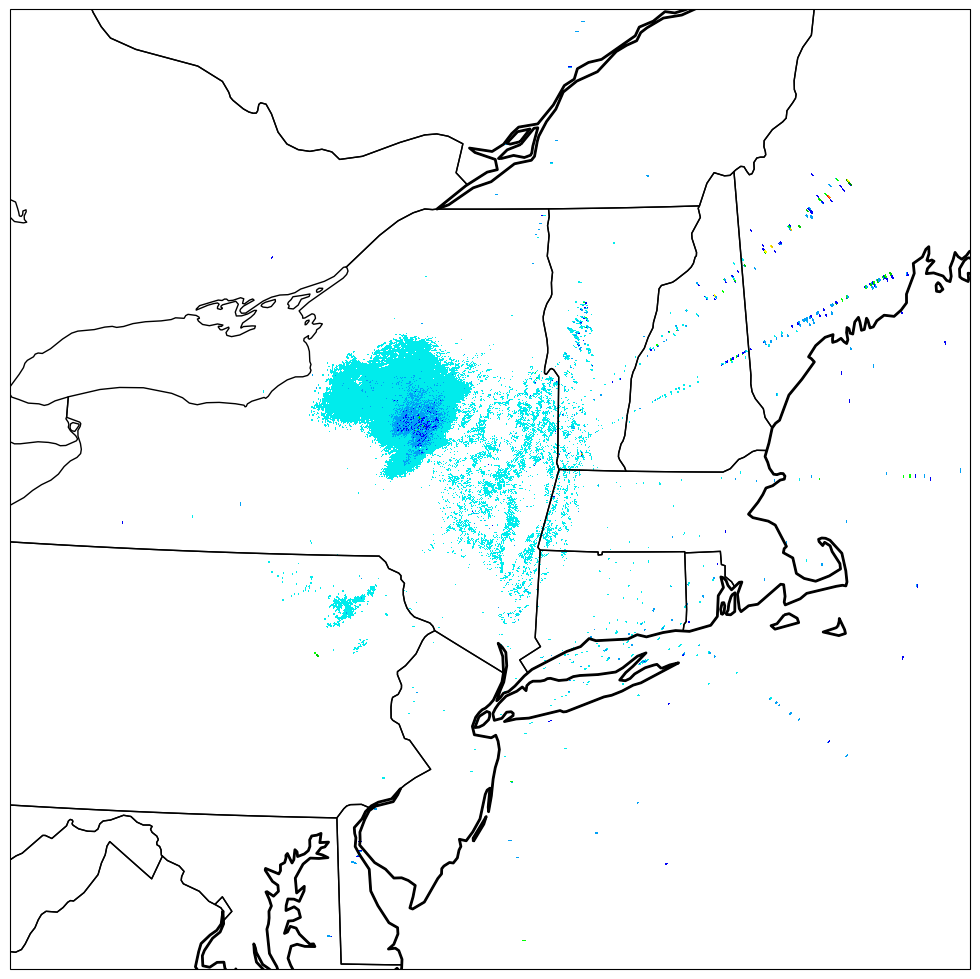

In [67]:
fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)
ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)

In [95]:
"""
====================================
Create a plot of NEXRAD reflectivity
====================================
An example which creates a plot containing the first collected scan from a
NEXRAD file.
"""
print(__doc__)

# Author: Jonathan J. Helmus (jhelmus@anl.gov)
# License: BSD 3 clause

import matplotlib.pyplot as plt

import pyart
from pyart.testing import get_test_data

# open the file, create the displays and figure
filename = get_test_data("Level2_KENX_20230205_1950.ar2v")
radar = pyart.io.read_nexrad_archive(filename)
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot(
    "reflectivity",
    0,
    title="NEXRAD Reflectivity",
    vmin=-32,
    vmax=64,
    colorbar_label="",
    ax=ax,
)
display.plot_range_ring(radar.range["data"][-1] / 1000.0, ax=ax)
display.set_limits(xlim=(-500, 500), ylim=(-500, 500), ax=ax)
plt.show()


Create a plot of NEXRAD reflectivity
An example which creates a plot containing the first collected scan from a
NEXRAD file.



ValueError: File 'Level2_KENX_20230205_1950.ar2v' is not in the registry.